This is a working notebook exploring if SVM is a useful tool to separate shadow and floodwaters. 

The notebook uses the rasterio.sample method to extract data at specific points identified in an ArcGIS shapefile.
This data is then used to fit/train and test a SVM model using both a linear and rbf kernel. 
The accuracy score and confusion matrix are calculated to quantify how well the model fits the test data. 

Inputs to model include combination of index raw values for:
"Dark" parameter, MBI, MSI, NDVI, NDWI0, NDWI1, NDWI2, NDWIcoastal-MSI, NDWIgreen-MSI
These index values are calculated using the notebook "ndwi_msi_with_modules"

The model is calibrated and then validated on data not included in either the training or intial testing of the model. 

Training/test data set represents 60% of overall dataset. Final validation is done with remaining 40%

In [1]:
# Import necessary packages
import os
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import geopandas as gpd
import rasterio as rio
# from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.covariance import EmpiricalCovariance
# from joblib import dump, load
import pickle

## Try SVM on raw data including: dark parameter, NDWIs, NDVI, MSI, and MBI data
- might be worth trying to add ndwi_yellow (ndwi2) based on improved threshold results.
- current model includes dark, mbi, msi, ndwi_coastal-msi, ndwi_green-msi
- ndwi/msi differences based on paper Xie et al (2016)

In [2]:
aoi = 'beira_ps'
beira_band_path = '..\\data\\'+aoi+"\\"
beira_raster_outputs_path = os.path.join(
    beira_band_path, "outputs\\raster_files\\")
beira_svm_outputs_path = os.path.join(
    beira_band_path, "final_outputs\\svm\\")

beira_raw_list = glob(beira_raster_outputs_path+"\\"+"*raw*")
beira_raw_list.sort()

In [3]:
# Set paths for validation data inputs
validation_data_path = os.path.join('..\\data\\combined\\validation\\')
beira_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\validationpoints_beira.shp")

svm_outputs_path = os.path.join(beira_band_path, "outputs\\svm\\")
try:
    os.makedirs(svm_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")

band_path directory already exists!


In [3]:
# # Read in data for aoi identified. 
# # Raw metric files must be available and named appropriately per ndwi_msi_with_modules notebook.
# # sample points availabel from data folder (?)
# aoi = 'beira_ps'
# band_path = '..\\data\\'+aoi+"\\"
# # sample_pts_path = os.path.join("validation","vector-data\\")
# # addded "raw" to try and fix issue
# raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")

# # raw_path = os.path.join("dg-data",aoi,"outputs","indices_and_mask_files","raw")
# raw_list = glob(raster_outputs_path+"\\"+"*raw*")
# raw_list.sort()
# # sample_pts = gpd.read_file(sample_pts_path+"validation_points_koumassi_60_percent.shp")

# validation_data_path = os.path.join(band_path,'validation\\')
# sample_pts = gpd.read_file(validation_data_path+"vector-data\\additional_val_points.shp")


# # validation_sample_pts = gpd.read_file(sample_pts_path+"validation_points_koumassi_40_percent.shp")
# # outputs_path = os.path.join("dg-data",aoi,"outputs","indices_and_mask_files")
# all_bands_path = os.path.join(raster_outputs_path + aoi+"_all_bands.tif")

# svm_outputs_path = os.path.join(band_path, "outputs\\svm_additional_points\\")
# # try:
# #     os.makedirs(svm_outputs_path)
# # except FileExistsError:
# #     print("band_path directory already exists!")


In [5]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(beira_sample_pts.geometry.x)
y_coords = tuple(beira_sample_pts.geometry.y)

In [7]:
# Get meta data for writing out SVM result
beira_all_bands_path = os.path.join(
    beira_raster_outputs_path + aoi+"_all_bands.tif")
with rio.open(beira_all_bands_path) as src:
    beira_all_bands_stack = src.read()
    stack_meta = src.meta
    beira_files_out_meta = src.meta.copy()
beira_files_out_meta['count'] = 1

In [18]:
# Sample index values at reference points for beira
# Create tuples of all x coordinates and y coordinates
x_coords_beira = tuple(beira_sample_pts.geometry.x)
y_coords_beira = tuple(beira_sample_pts.geometry.y)

i = 0
index_list = []
filename = []

for raw in beira_raw_list:
    sampled_values = []

    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords_beira, y_coords_beira)):
            i = i+1

        # Note that each val is an individual numpy array
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[42:77])

labels = filename
index_vals_beira = pd.DataFrame(np.concatenate(index_list))
index_vals_beira = index_vals_beira.transpose()
index_vals_beira.columns = labels

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_beira.csv"
index_vals_beira.to_csv(filepath)
index_vals_beira.head()

,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,0.0371,0.000000,0.224895,-0.068783,0.398844,0.173948,0.375375,0.150480
1,0.0859,0.003027,0.207266,0.061919,0.212982,0.005716,0.347899,0.140633
2,0.0215,0.000000,0.195886,-0.060870,0.557895,0.362008,0.520000,0.324114
3,0.0342,0.002386,0.221775,-0.004115,0.771812,0.550037,0.856540,0.634765
4,0.0503,0.001500,0.239355,-0.109827,-0.146814,-0.386169,0.167002,-0.072353


In [27]:
# Combine validation data with index values for beira
valid_data_beira = pd.read_csv(
    validation_data_path+"validationpoints_beira.csv")
train_data_beira = pd.concat(
    [valid_data_beira, index_vals_beira], axis=1, sort=False)
train_data_beira.head()
train_data_beira = train_data_beira.drop(['OBJECTID'], axis=1)
# train_data_beira['ClassValue'].value_counts()

In [30]:
# Define training dataset
XX = train_data_beira.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]]
X = train_data_beira.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]].values
y = train_data_beira.iloc[:, 0].values

In [37]:
# Split training dataset, test size is 40%, training size 60%
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)

In [38]:
# Define SVC classifier. Once established, comment out.
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

0.9425287356321839

In [56]:
# Save out SVM classifier with highest accuracy score. 

# pickled accuracy score of 0.93227
pickle.dump(clf, open(svm_outputs_path+'pickle_svm_additional_points', 'wb'))


In [ ]:
# Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X, y)

In [39]:
# Explore SVM classifier with rbf kernel
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(Xtrain, ytrain)
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest, ypred_rbf)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8850574712643678

[[61  3  0  1]
 [10 59  0  0]
 [ 0  1 61  0]
 [ 0  0  0 65]]


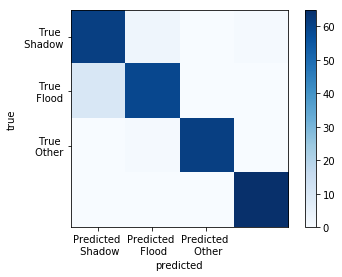

In [40]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))
plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

[[57  7  0  1]
 [20 49  0  0]
 [ 0  0 62  0]
 [ 1  1  0 63]]


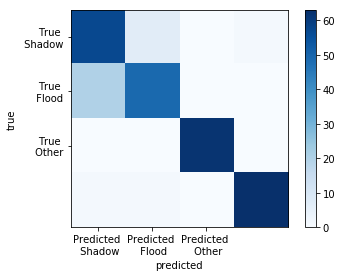

In [41]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(ytest, ypred_rbf))
plt.imshow(confusion_matrix(ytest, ypred_rbf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
# Try Maximum Likelihood Estimator covariance model ?

In [ ]:
# cov = EmpiricalCovariance().fit(Xtrain)
# ypred_cov = cov.predict(Xtest)
# accuracy_score(ytest, ypred_cov)

Linear kernel appears to be better fit for data, depending on which parameters are included in model.
Tried playing with different combinations of indices. Current model includes the following combination:

- Dark parameter
- MBI
- MSI
- NDVI
- NDWIcoastal - MSI
- NDWIgreen - MSI

# Developing map based on trained svm model

In [85]:
# Load saved SVM classifer
loaded_clf = pickle.load(open(svm_outputs_path+'pickle_svm_additional_points', 'rb'))

[1 2 3 4]


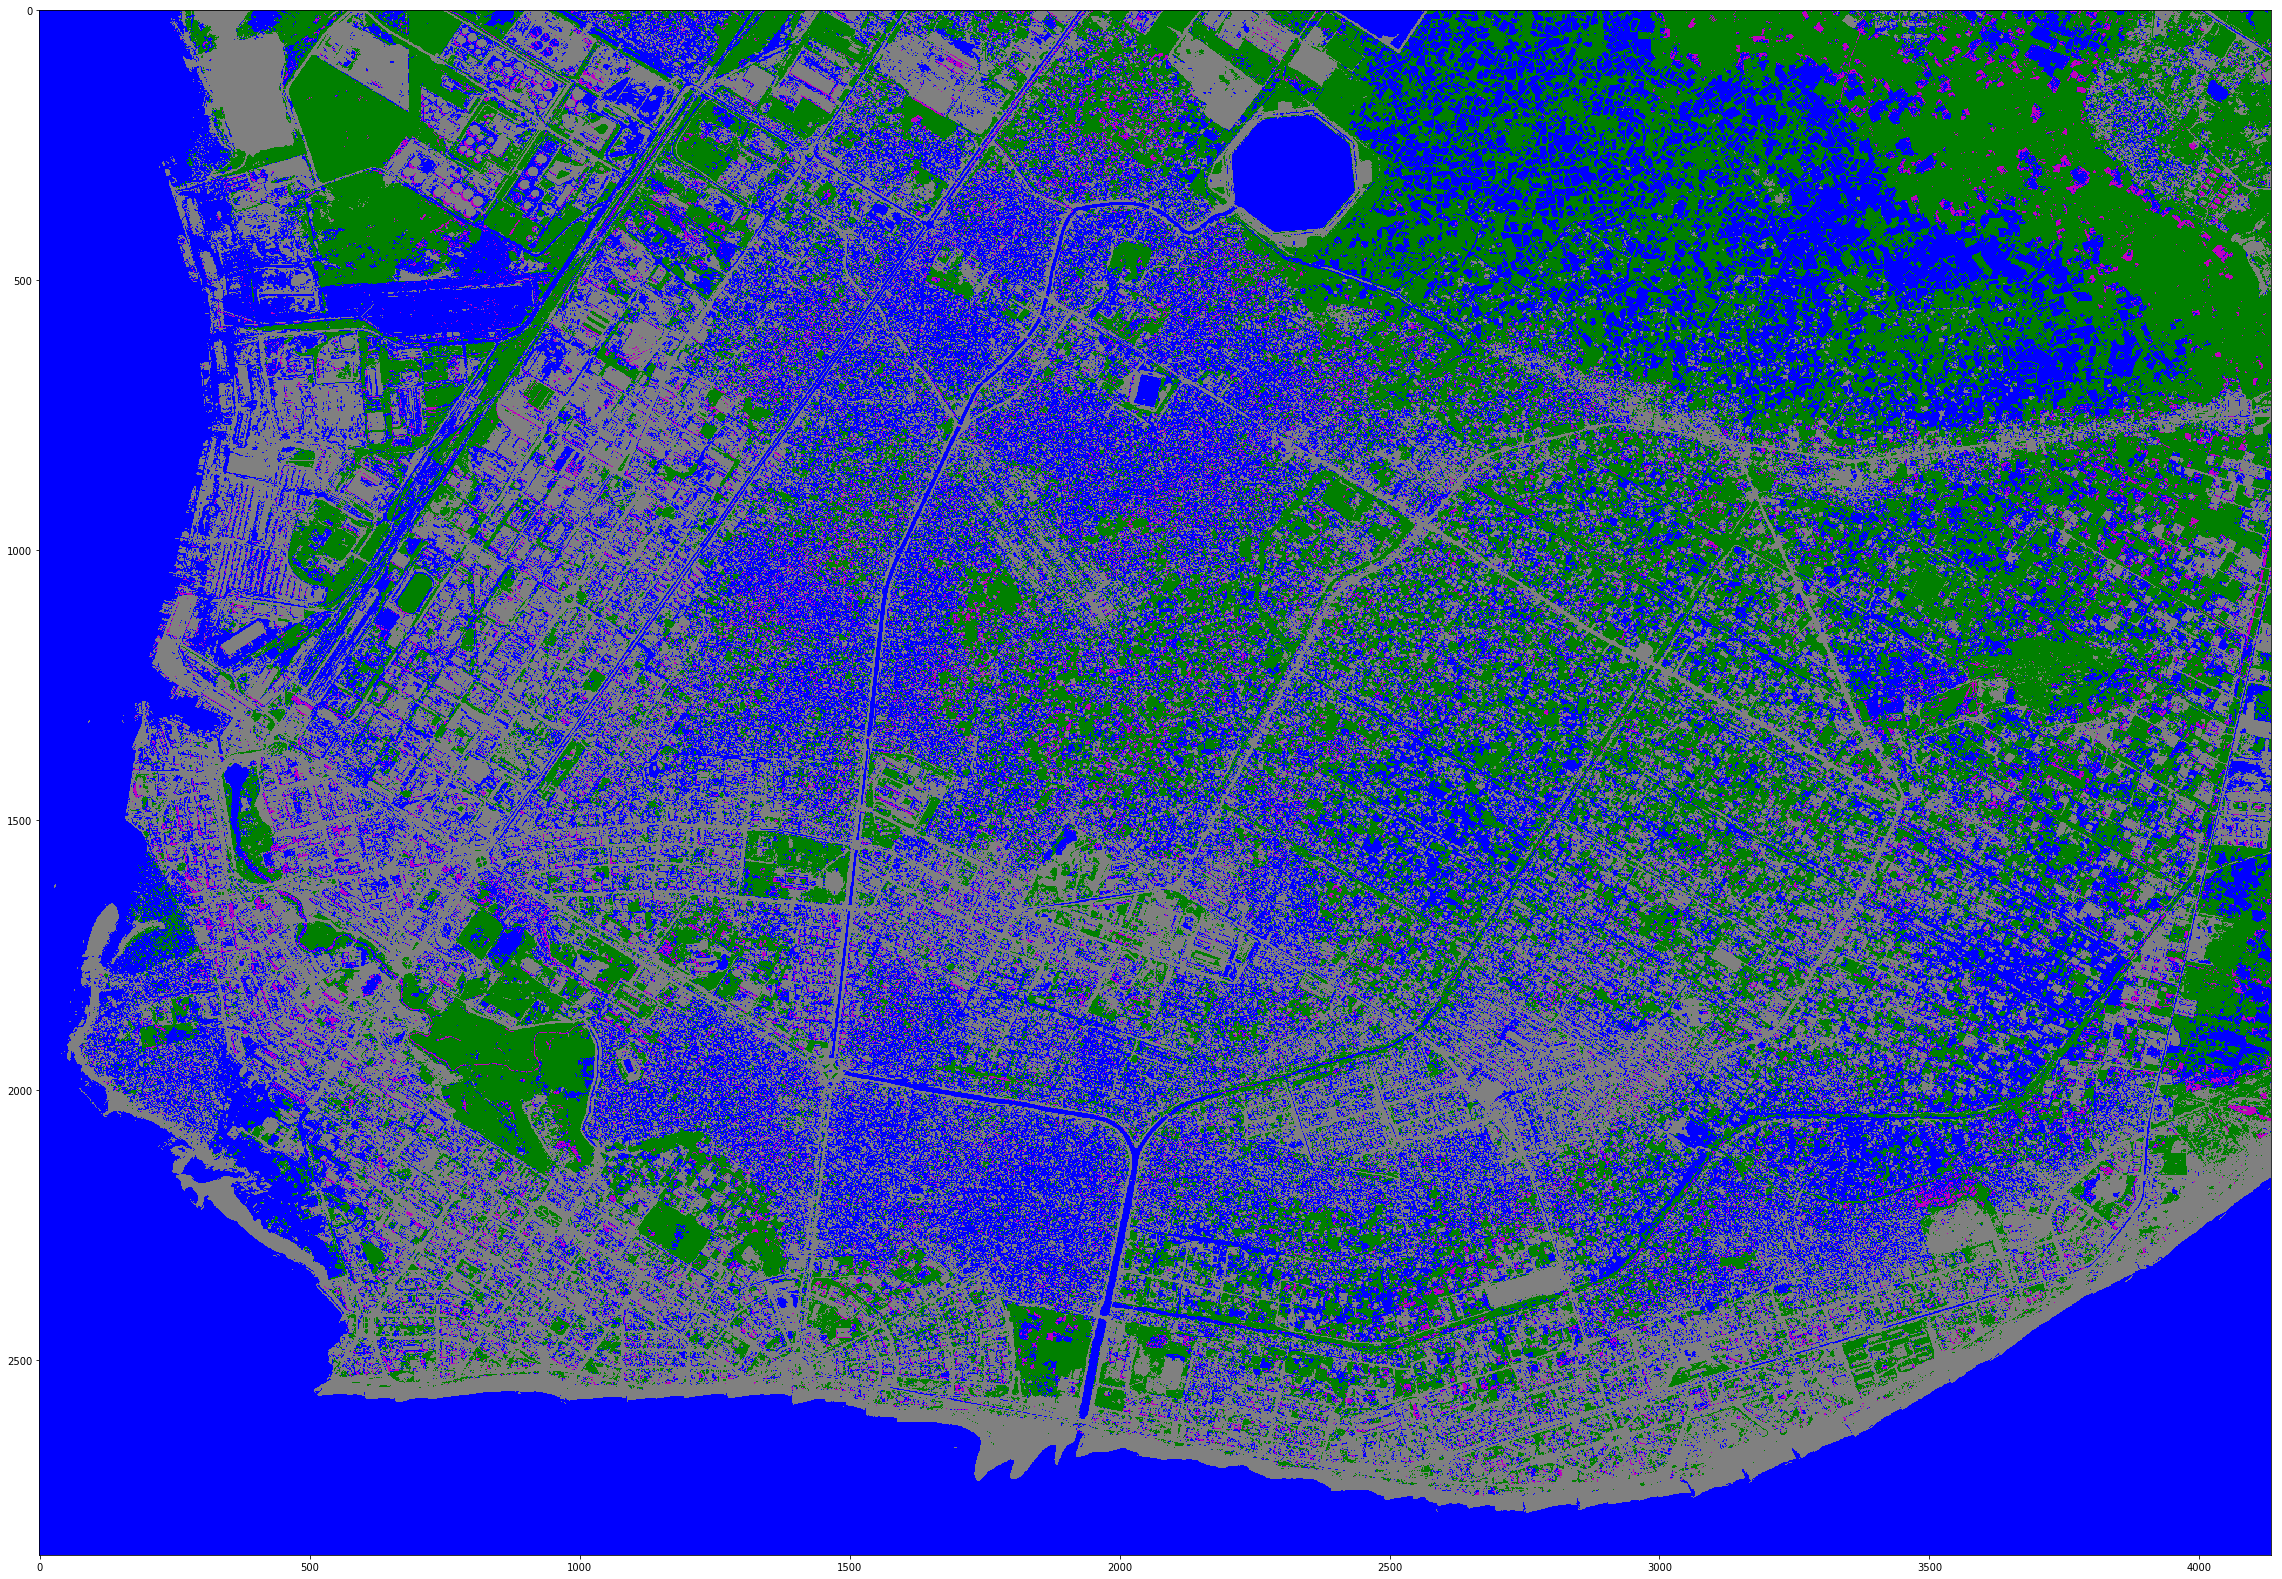

In [45]:
# testing loaded clf
index_stack, meta = es.stack(beira_raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,8)
predictedClass = clf.predict(X_index)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
# predictedClass += 1

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
im = ax.imshow(pred_data,cmap=cmap)
print(np.unique(pred_data))
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

In [ ]:
np.count_nonzero(pred_data == 1)

In [ ]:
index_stack, meta = es.stack(raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,5)
predictedClass = loaded_clf.predict(X_index)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
# predictedClass += 1

In [ ]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','grey'])
im = ax.imshow(pred_data,cmap=cmap)
print(np.unique(pred_data))
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_out = pred_data[np.newaxis,:]
with rio.open(svm_outputs_path+'SVM_map.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

# Validation with 40% of data held back from SVM model development

In [ ]:
# # Create tuples of all x coordinates and y coordinates 
# # x_valid_coords = tuple(validation_sample_pts.geometry.x)
# # y_valid_coords = tuple(validation_sample_pts.geometry.y)
# x_valid_coords = tuple(sample_pts_40perc.geometry.x)
# y_valid_coords = tuple(sample_pts_40perc.geometry.y)
# # sampled_values = []
# i = 0
# index_valid_list = []
# filename=[]

# for raw in raw_list:
#     sampled_values = []
    
#     # Sample raster at each combo of x and y coordinates
#     with rio.open(raw) as src:
#         for val in src.sample(zip(x_valid_coords, y_valid_coords)):
#             i = i+1
#         # Note that each val is an individual numpy array
#         # print(val.shape)
#             sampled_values.append(val)
#         arr = np.array([sampled_values]).squeeze()
#         index_valid_list.append([arr])
#         filename.append(raw[57:78])
        

# labels = filename
# index_valid_df = pd.DataFrame(np.concatenate(index_valid_list))
# index_valid_df = index_valid_df.transpose()
# index_valid_df.columns=labels
# filepath = validation_data_path+"raw_index_values_40perc.csv"
# index_valid_df.to_csv(filepath) 

In [ ]:
# valid_40_data = pd.read_csv(validation_data_path+"koumassi_validation_data_40_percent.csv")
# external_valid_df = pd.concat([valid_40_data,index_valid_df], axis=1, sort=False)

In [ ]:
# # valid_data = pd.read_csv(validation_data_path+"validation_raw_index_40_percent.csv")
# # Xvalid = valid_data.iloc[:,[2,3,4,9,11]].values
# # yvalid = valid_data.iloc[:,1].values

# Xvalid = external_valid_df.iloc[:,[2,3,4,5,6]].values
# yvalid = external_valid_df.iloc[:,1].values

In [ ]:
# ypred_valid = loaded_clf.predict(Xvalid)
# accuracy_score(yvalid, ypred_valid)

In [ ]:
# #Print confusion matrix for linear kernel SVM
# print(confusion_matrix(ytest, ypred))
# plt.imshow(confusion_matrix(ytest, ypred),
#            cmap='Blues', interpolation='nearest')
# plt.colorbar()
# plt.grid(False)
# plt.ylabel('true')
# plt.xlabel('predicted');

In [ ]:
# #Print confusion matrix for linear kernel SVM
# print(confusion_matrix(yvalid, ypred_valid))

# plt.imshow(confusion_matrix(yvalid, ypred_valid),
#            cmap='Blues', interpolation='nearest')
# plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
# plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
# plt.colorbar()
# plt.grid(False)
# plt.ylabel('true')
# plt.xlabel('predicted');

In [ ]:
# ypred_rbf_valid = clf_rbf.predict(Xvalid)
# accuracy_score(yvalid, ypred_rbf_valid)

In [ ]:
# #Print confusion matrix for rbf kernel SVM
# print(confusion_matrix(yvalid, ypred_rbf_valid))

# plt.imshow(confusion_matrix(yvalid, ypred_rbf_valid),
#            cmap='Blues', interpolation='nearest')
# plt.colorbar()
# plt.grid(False)
# plt.ylabel('true')
# plt.xlabel('predicted');

# Random forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf_random_forest = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=10)

In [172]:
# Split training dataset, test size is 40%, training size 60%
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(X, y, test_size=0.4)

In [173]:
clf_random_forest.fit(Xtrain_rf, ytrain_rf)
ypred_random_forest = clf_random_forest.predict(Xtest_rf)
accuracy_score(ytest_rf, ypred_random_forest)

0.8824701195219123

[[207   8   0]
 [ 17 160   1]
 [  0   9 100]]


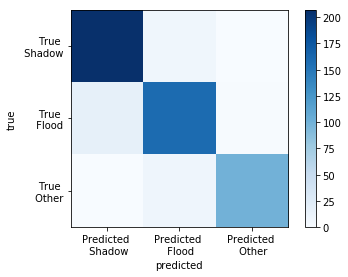

In [118]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_rf, ypred_random_forest))
plt.imshow(confusion_matrix(ytest_rf, ypred_random_forest),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [119]:
#pickled 0.93027888 accuracy score
pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_random_forest_additional_points', 'wb'))

In [ ]:
# Plot random forest
# predictedClass_random_forest = clf_random_forest.predict(X)

In [ ]:
# from matplotlib.colors import ListedColormap
# fig, ax = plt.subplots(figsize = (40,40))
# pred_data = predictedClass_random_forest.reshape(index_im.shape[:2])
# cmap = ListedColormap(['m','blue','grey'])
# im = ax.imshow(pred_data,cmap=cmap)
# print(np.unique(pred_data))
# # cat_names = ["1","2","3","4","5","6","7","8"]
# # ep.draw_legend(im,titles=cat_names)
# # plt.title("K-means - 8 clusters - 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# Plot random forest

In [ ]:
# testing loaded clf
index_stack, meta = es.stack(raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,5)
predictedClass_random_forest = clf_random_forest.predict(X_index)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
# predictedClass += 1

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data_random_forest = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','grey'])
im = ax.imshow(pred_data_random_forest,cmap=cmap)
print(np.unique(pred_data))
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_out = pred_data[np.newaxis,:]
with rio.open(svm_outputs_path+'random_forest_map.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_random_forest.astype('float32'),1)

In [ ]:
# ypred_valid_rf = clf_random_forest.predict(Xvalid)
# accuracy_score(yvalid_rf, ypred_valid_rf)

# External 40% validation

In [ ]:
ypred_valid_rf = clf_random_forest.predict(Xvalid)
accuracy_score(yvalid, ypred_valid_rf)

In [ ]:
#Print confusion matrix for random forest
print(confusion_matrix(yvalid, ypred_valid_rf))

plt.imshow(confusion_matrix(yvalid, ypred_valid_rf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_rf, ypred_random_forest))

plt.imshow(confusion_matrix(ytest_rf, ypred_random_forest),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(yvalid_rf, ypred_valid_rf))

plt.imshow(confusion_matrix(yvalid_rf, ypred_valid_rf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
# all_bands_scaled = all_bands_stack/10000
# coastal = all_bands_scaled[0]
# blue = all_bands_scaled[1]
# green = all_bands_scaled[2]
# yellow = all_bands_scaled[3]
# red = all_bands_scaled[4]
# rededge = all_bands_scaled[5]
# nearir1 = all_bands_scaled[6]
# nearir2 = all_bands_scaled[7]

# dark = rededge+nearir1+nearir2
# # msi = calc_msi(raster_input=img_arr, s_min=2, s_max=52, s_delta = 5)
# # mbi = calc_mbi(raster_input=img_arr,s_min=2, s_max=52,s_delta=5)
# ndwi_coastal = (coastal - nearir2)/(coastal+nearir2)
# ndwi_green = (green - nearir2)/(green+nearir2)
# ndwi_coastal_msi = ndwi_coastal 
# ndwi_green_msi = ndwi_green 
# svm_inputs_list = ['dark','ndwi_coastal', 'ndwi_green']
# svm_inputs_list.sort()
# svm_inputs_path = os.path.join( "svm_inputs_stack_delete.tif")
# feature_image, svm_meta = et.spatial.stack(svm_inputs_list,svm_inputs_path)